## SARIMAX Time Series Analysis of Delayed Flights

In this notebook, we attempt to build a series of models to predict how many delayed flights will occur on a given day. We will need to aggregate data from all airlines to get a daily time series.

In [1]:
# Import libraries

import pandas as pd
import duckdb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

We use *duckdb* to query a large parquet file and produce a more compact Pandas dataframe. Resulting dataframe shows the impact of the COVID-19 pandemic, particularly in mid-2020.

<Axes: xlabel='FlightDate'>

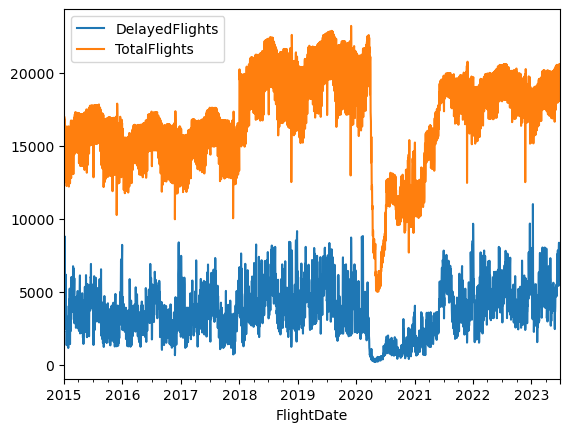

In [2]:
# Initial query to get flight counts aggregated by day across all airlines

qstr = '''
select FlightDate, count(*) as TotalFlights,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights
from 'bts_faa_coords.parquet'
group by FlightDate
order by FlightDate
'''

df = duckdb.query(qstr).df()
df.FlightDate = pd.to_datetime(df.FlightDate)
df = df.set_index('FlightDate')

# First look at flight counts for the duration of the dataset

df.plot(y=['DelayedFlights', 'TotalFlights'])

Avoid COVID-19 impacts by using data from 2015-2018 for training, and 2019 for testing.

In [3]:
# Just use data from 2015-2019. 2015-2018 for training, 2019 for testing

df = df[:'2019-12-31']
df_train = df[:'2018-12-31']
df_test = df['2019-01-01':]

### Check for stationarity and select hyperparameters for ARIMA model

In [4]:
# There is some seasonality evident and perhaps some trending.
# Test for stationarity of the data before moving forward.

result = adfuller(df_train.DelayedFlights)
print(f'Augmented Dickey Fuller Stat: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')
if result[0] < result[4]['1%']:
    print('Reject the null hypothesis: Data is stationary.')
else:
    print('Accept the null hypothesis: Data is not stationary.')

Augmented Dickey Fuller Stat: -4.457108715185257
p-value: 0.00023487310581855834
Critical values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}
Reject the null hypothesis: Data is stationary.


In [5]:
# Use pmdarima to grid search for the parameters of an ARIMA model
# Ignore seasonality for the moment

best_arima = pm.auto_arima(df_train.DelayedFlights,
                          start_p=1, start_q=1, test='adf',
                          max_p=3, max_q=3,
                          m=1, d=None, seasonal=False,
                          error_action='warn', suppress_warnings=True,
                          stepwise=True)

In [6]:
# So if we ignore seasonality, the best choice is ARIMA(1,0,2)
best_arima

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

PredictedDelayedFlights    4221.570429
DelayedFlights             4639.986301
Error                       418.415872
PctError                     -0.022392
AbsoluteError              1335.521350
AbsolutePctError              0.304327
dtype: float64

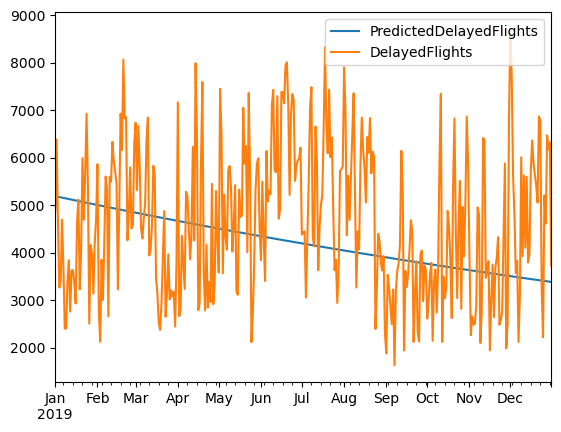

In [7]:
# Clearly the ARIMA predictions do not capture the variance in the test data

df_arima = pd.DataFrame([best_arima.predict(n_periods=365), df_test.DelayedFlights]).T
df_arima.columns=['PredictedDelayedFlights','DelayedFlights']
df_arima.plot()

df_arima['Error'] = df_arima.DelayedFlights - df_arima.PredictedDelayedFlights
df_arima['PctError'] = df_arima.Error/df_arima.DelayedFlights
df_arima['AbsoluteError'] = df_arima.Error.abs()
df_arima['AbsolutePctError'] = df_arima.PctError.abs()
df_arima.mean()


### Identify hyperparameters for SARIMA

In [15]:
# Grid search again, this time with seasonality (SARIMA)

best_sarima = pm.auto_arima(df_train.DelayedFlights,
                            start_p=1, start_q=1, test='adf',
                            max_p=3, max_q=3,
                            m=7, # Assume seasonality is monthly
                            D=1, # Order of seasonal differencing
                            d=None, seasonal=True,
                            error_action='warn', suppress_warnings=True,
                            stepwise=True)


In [16]:
# With weekly seasonality, the best model was SARIMA(0,0,2)(1,1,1,7)
# With monthly seasonality, the best model was SARIMA(1,0,0)(2,1,1,30)

best_sarima

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(1, 1, 1, 7),
      suppress_warnings=True)

PredictedDelayedFlights    4587.919092
DelayedFlights             4639.986301
Error                        52.067209
PctError                     -0.096184
AbsError                   1266.258043
AbsolutePctError              0.304448
dtype: float64

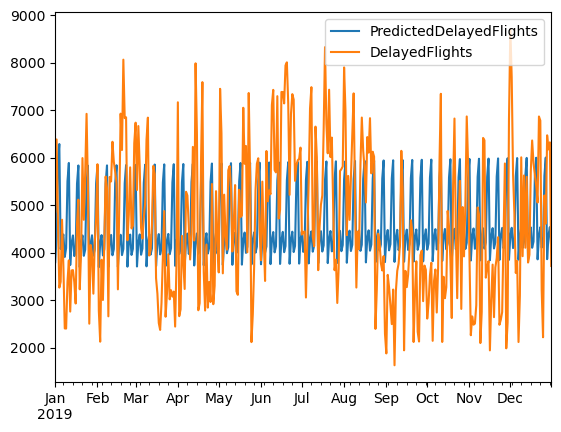

In [17]:
# SARIMA weekly predictions - More variance, but not enough

df_sarima = pd.DataFrame([best_sarima.predict(n_periods=365), df_test.DelayedFlights]).T
df_sarima.columns=['PredictedDelayedFlights','DelayedFlights']
df_sarima.plot()

df_sarima['Error'] = df_sarima.DelayedFlights - df_sarima.PredictedDelayedFlights
df_sarima['PctError'] = df_sarima.Error/df_sarima.DelayedFlights
df_sarima['AbsError'] = df_sarima.Error.abs()
df_sarima['AbsolutePctError'] = df_sarima.PctError.abs()

df_sarima.mean()

PredictedDelayedFlights    6327.128631
DelayedFlights             4639.986301
Error                     -1687.142330
PctError                     -0.548796
AbsError                   2052.406537
AbsolutePctError              0.601559
dtype: float64

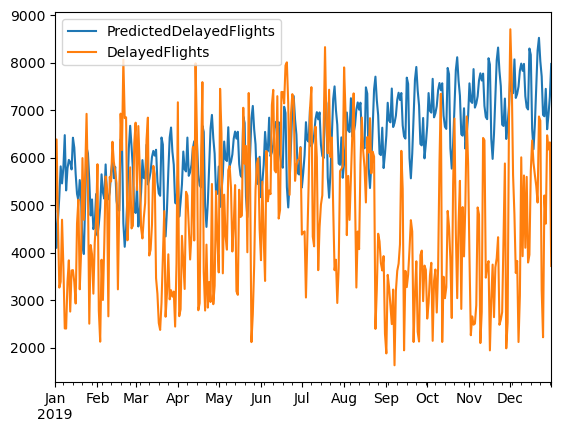

In [14]:
# SARIMA monthly predictions - Pattern starts to look closer but trend is off and error has increased

df_sarima30 = pd.DataFrame([best_sarima.predict(n_periods=365), df_test.DelayedFlights]).T
df_sarima30.columns=['PredictedDelayedFlights','DelayedFlights']
df_sarima30.plot()

df_sarima30['Error'] = df_sarima30.DelayedFlights - df_sarima30.PredictedDelayedFlights
df_sarima30['PctError'] = df_sarima30.Error/df_sarima30.DelayedFlights
df_sarima30['AbsError'] = df_sarima30.Error.abs()
df_sarima30['AbsolutePctError'] = df_sarima30.PctError.abs()

df_sarima30.mean()

### Try different combinations for SARIMA using *statsmodels*

In [45]:
# Switch to statsmodels - answers are not quite the same.
# Test several combinations to find better fit.

model=sm.tsa.statespace.SARIMAX(df_train.DelayedFlights,
                                order=(1,0,2),
                                seasonal_order=(3,1,0,30))
results=model.fit(maxiter=100)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46604D+00    |proj g|=  1.19849D-01


 This problem is unconstrained.



At iterate    5    f=  8.44370D+00    |proj g|=  2.35057D-02

At iterate   10    f=  8.43335D+00    |proj g|=  8.67387D-03

At iterate   15    f=  8.43218D+00    |proj g|=  4.19539D-04

At iterate   20    f=  8.43217D+00    |proj g|=  1.29027D-03

At iterate   25    f=  8.43111D+00    |proj g|=  2.59061D-02

At iterate   30    f=  8.38995D+00    |proj g|=  1.32004D-01

At iterate   35    f=  8.36863D+00    |proj g|=  2.14265D-03

At iterate   40    f=  8.36821D+00    |proj g|=  1.66737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     46      1     0     0   1.391D-05   8.368D+00
  F =   8.36820312790

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 30)   Log Likelihood              -12225.945
Date:                             Sun, 15 Oct 2023   AIC                          24465.890
Time:                                     18:54:53   BIC                          24502.752
Sample:                                 01-01-2015   HQIC                         24479.655
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9567      0.011     85.472      0.000       0.935       0.979
ma.L1         -0.4282      0.027    -15.821      0.000      -0.481      -0.375
ma.L2         -0.3092      0.028    -11.071      0.000      -0.364      -0.254
ar.S.L30      -0.7976      0.026    -30.986      0.000      -0.848      -0.747
ar.S.L60      -0.4491      0.033    -13.454      0.000      -0.514      -0.384
ar.S.L90      -0.2201      0.028     -7.962      0.000      -0.274      -0.166
sigma2      1.535e+06   5.37e+04     28.589      0.000    1.43e+06    1.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                10.79
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean      4718.698587
DelayedFlights      4639.986301
Error                -78.712286
PctError              -0.152036
AbsoluteError       1479.690892
AbsolutePctError       0.374647
dtype: float64

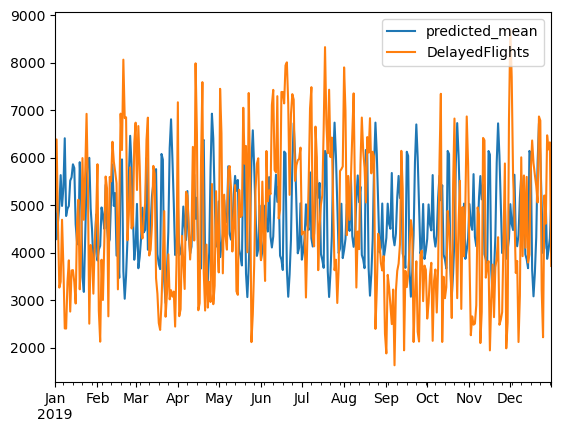

In [46]:
df_res = pd.DataFrame([results.forecast(365), df_test.DelayedFlights]).T
df_res.plot()

df_res['Error'] = df_res.DelayedFlights - df_res.predicted_mean
df_res['PctError'] = df_res.Error/df_res.DelayedFlights
df_res['AbsoluteError'] = df_res.Error.abs()
df_res['AbsolutePctError'] = df_res.PctError.abs()

df_res.mean()

# Using (1,0,0),(2,1,1,30) - 34 iterations
# predicted_mean      3645.011294
# DelayedFlights      4639.986301
# Error                994.975007
# PctError               0.112457
# AbsoluteError       1463.304301
# AbsolutePctError       0.297444

# Using (1,0,2),(2,1,1,30) - 70 iterations
# predicted_mean      3734.795828
# DelayedFlights      4639.986301
# Error                905.190473
# PctError               0.089123
# AbsoluteError       1466.333800
# AbsolutePctError       0.303659

# Using (1,0,2),(2,1,0,30) - 52 iterations
# predicted_mean      4858.259350
# DelayedFlights      4639.986301
# Error               -218.273049
# PctError              -0.187033
# AbsoluteError       1561.853766
# AbsolutePctError       0.400902

# Using (0,0,2),(2,1,1,30) - 41 iterations
# predicted_mean      3914.341894
# DelayedFlights      4639.986301
# Error                725.644407
# PctError               0.045949
# AbsoluteError       1394.928690
# AbsolutePctError       0.299952

# Using (0,0,2),(2,1,0,30) - 41 iterations
# predicted_mean      4346.890153
# DelayedFlights      4639.986301
# Error                293.096148
# PctError              -0.061863
# AbsoluteError       1577.043684
# AbsolutePctError       0.372200

# Using (0,0,2),(1,1,1,30) - 27 iterations
# predicted_mean      3635.093961
# DelayedFlights      4639.986301
# Error               1004.892340
# PctError               0.114429
# AbsoluteError       1464.935328
# AbsolutePctError       0.297060

# Using (0,0,2),(1,1,1,7) - 36 iterations
# predicted_mean      4401.405808
# DelayedFlights      4639.986301
# Error                238.580493
# PctError              -0.051204
# AbsoluteError       1220.080013
# AbsolutePctError       0.282965

# Using (0,0,2),(2,1,0,7) - 22 iterations
# predicted_mean      5183.533003
# DelayedFlights      4639.986301
# Error               -543.546701
# PctError              -0.237302
# AbsoluteError       1976.829149
# AbsolutePctError       0.482479

# Using (1,0,2),(2,1,0,7) - 33 iterations
# predicted_mean      5454.193917
# DelayedFlights      4639.986301
# Error               -814.207616
# PctError              -0.302533
# AbsoluteError       2050.840635
# AbsolutePctError       0.508788

# Using (1,0,2),(3,1,0,30) - 43 iterations
# predicted_mean      4718.698587
# DelayedFlights      4639.986301
# Error                -78.712286
# PctError              -0.152036
# AbsoluteError       1479.690892
# AbsolutePctError       0.374647

### SARIMAX - Select exogenous variables

In [47]:
# Now we will get some additional information to use for exogenous variables

qstr = '''
select FlightDate, count(*) as TotalFlights, count(distinct Tail_Number) as Aircraft,
mean(Distance) as Distance, 
mean(case when "YEAR MFR"!='    ' then cast("YEAR MFR" as Integer) end) as YearMfr,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights,
count(case when MFR_aircraft like '%AIRBUS%' then MFR_aircraft end) as AirbusFlights,
count(case when MFR_aircraft like '%BOEING%' then MFR_aircraft end) as BoeingFlights,
count(case when MFR_aircraft like '%EMBRAER%' then MFR_aircraft end) as EmbraerFlights,
count(case when MFR like 'CFM%' then MFR end) as CFMFlights,
count(case when MFR like 'GE%' then MFR end) as GEFlights,
count(case when MFR like 'P%' then MFR end) as PWFlights,
count(case when MFR like 'ROLL%' then MFR end) as RRFlights,
from 'bts_faa_coords.parquet'
group by FlightDate
order by FlightDate
'''

df = duckdb.query(qstr).df()
df.FlightDate = pd.to_datetime(df.FlightDate)
df = df.set_index('FlightDate')

In [48]:
df

,TotalFlights,Aircraft,Distance,YearMfr,DelayedFlights,DivertedFlights,CancelledFlights,AirbusFlights,BoeingFlights,EmbraerFlights,CFMFlights,GEFlights,PWFlights,RRFlights
FlightDate,,,,,,,,,,,,,,
2015-01-01,14150,3753,861.363180,2002.168597,3700,20,476,2673,5103,1351,4922,2188,1159,936
2015-01-02,16981,3823,839.398563,2000.519684,5556,29,260,3048,6352,1588,6063,2797,1431,1119
2015-01-03,15660,3761,848.447446,2001.977598,7716,53,334,2686,5831,1487,5452,2721,1280,1039
2015-01-04,16583,3829,837.967979,2001.954416,8789,32,434,2978,6050,1621,5778,2783,1418,1090
2015-01-05,16787,3813,820.262227,2001.110999,6698,40,440,2987,6210,1617,5929,2787,1384,1096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,20546,4601,834.893702,2010.603346,7522,110,1982,5918,9197,2568,10534,4870,689,418
2023-06-27,19269,4456,835.573616,2010.684581,6441,59,1891,5156,8730,2469,9771,4614,639,404
2023-06-28,19728,4509,834.919404,2010.621916,6160,21,1046,5381,8824,2464,10001,4721,654,401


In [49]:
df_train = df[:'2018-12-31']
df_test = df['2019-01-01':'2019-12-31']

In [54]:
# Remove EmbraerFlights and RRFlights
# Also Remove Aircraft and Distance
# Put back Aircraft and Distance. Remove PWFlights
# Remove all engine variables

# exog_cols = ['Aircraft','Distance','YearMfr','BoeingFlights']
exog_cols = ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights','EmbraerFlights',
                'CFMFlights','GEFlights','PWFlights','RRFlights']
exog = df_train[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(3,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16239D+01    |proj g|=  5.50371D+01


 This problem is unconstrained.



At iterate    5    f=  1.45573D+01    |proj g|=  4.97436D+01

At iterate   10    f=  1.08129D+01    |proj g|=  2.55114D+00

At iterate   15    f=  8.53828D+00    |proj g|=  2.71065D+00

At iterate   20    f=  8.52306D+00    |proj g|=  3.79199D-01

At iterate   25    f=  8.52225D+00    |proj g|=  8.59525D-03

At iterate   30    f=  8.52202D+00    |proj g|=  4.14077D-01

At iterate   35    f=  8.52074D+00    |proj g|=  1.41672D-01

At iterate   40    f=  8.52067D+00    |proj g|=  2.58338D-02

At iterate   45    f=  8.51991D+00    |proj g|=  5.17182D-01

At iterate   50    f=  8.51872D+00    |proj g|=  1.74017D-01

At iterate   55    f=  8.51571D+00    |proj g|=  4.74573D-02

At iterate   60    f=  8.51541D+00    |proj g|=  3.37260D-02

At iterate   65    f=  8.51508D+00    |proj g|=  1.66687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 30)   Log Likelihood              -12440.521
Date:                             Sun, 15 Oct 2023   AIC                          24915.043
Time:                                     19:50:57   BIC                          25004.567
Sample:                                 01-01-2015   HQIC                         24948.472
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Aircraft           2.3556      0.464      5.077      0.000       1.446       3.265
Distance          24.7773      1.255     19.740      0.000      22.317      27.237
YearMfr         -188.2252     50.964     -3.693      0.000    -288.113     -88.337
AirbusFlights      0.4797      0.313      1.531      0.126      -0.134       1.094
BoeingFlights      1.5882      0.465      3.417      0.001       0.677       2.499
EmbraerFlights    -0.2324      0.561     -0.415      0.678      -1.331       0.866
CFMFlights        -0.7635      0.486     -1.571      0.116      -1.716       0.189
GEFlights          0.4040      0.258      1.568      0.117      -0.101       0.909
PWFlights          0.8623      0.438      1.968      0.049       0.003       1.721
RRFlights          0.4352      0.669      0.650      0.515      -0.876       1.747
ar.L1              0.8721      0.041     21.503      0.000       0.793       0.952
ma.L1             -0.8213      0.042    -19.366      0.000      -0.904      -0.738
ma.L2             -0.0475      0.014     -3.304      0.001      -0.076      -0.019
ar.S.L30           0.0057      0.003      1.767      0.077      -0.001       0.012
ar.S.L60          -0.0073      0.002     -3.102      0.002      -0.012      -0.003
ar.S.L90          -0.0014      0.001     -1.486      0.137      -0.003       0.000
sigma2          1.468e+06      0.032   4.62e+07      0.000    1.47e+06    1.47e+06
===================================================================================
Ljung-Box (L1) (Q):                 310.25   Jarque-Bera (JB):                18.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+22. Standard errors may be unstable.
"""

predicted_mean      4612.022085
DelayedFlights      4639.986301
Error                 27.964217
PctError              -0.069172
AbsoluteError       1443.589941
AbsolutePctError       0.341164
dtype: float64

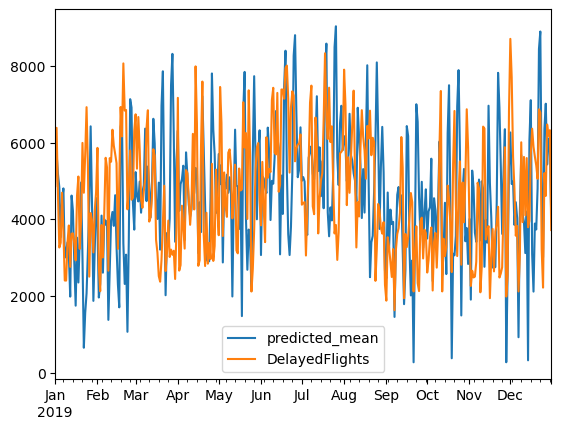

In [55]:
exog_test = df_test[exog_cols]

df_res = pd.DataFrame([results.forecast(365, exog=exog_test), df_test.DelayedFlights]).T
df_res.plot()

df_res['Error'] = df_res.DelayedFlights - df_res.predicted_mean
df_res['PctError'] = df_res.Error/df_res.DelayedFlights
df_res['AbsoluteError'] = df_res.Error.abs()
df_res['AbsolutePctError'] = df_res.PctError.abs()
df_res.mean()

# Using exog ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights','EmbraerFlights',
#                'CFMFlights','GEFlights','PWFlights','RRFlights'] - 65 iterations
# predicted_mean      4601.468961
# DelayedFlights      4639.986301
# Error                 38.517341
# PctError              -0.066431
# AbsoluteError       1442.676464
# AbsolutePctError       0.340554

# Remove RRFlights and EmbraerFlights - 74 iterations- slight increase in error
# predicted_mean      4651.590290
# DelayedFlights      4639.986301
# Error                -11.603988
# PctError              -0.078546
# AbsoluteError       1447.714760
# AbsolutePctError       0.343632

# Also remove Aircraft and Distance - 52 iterations - substantial increase in error
# predicted_mean      5200.688177
# DelayedFlights      4639.986301
# Error               -560.701876
# PctError              -0.227412
# AbsoluteError       1615.889126
# AbsolutePctError       0.407280

# Put back Aircraft and Distance. Remove PWFlights - 64 iterations - better but not minimum
# predicted_mean      4764.198780
# DelayedFlights      4639.986301
# Error               -124.212478
# PctError              -0.105670
# AbsoluteError       1466.656224
# AbsolutePctError       0.352798

# Remove all engine variables - 59 iterations - still better - seems a good balance not using too many exogs
# predicted_mean      4498.790480
# DelayedFlights      4639.986301
# Error                141.195822
# PctError              -0.044714
# AbsoluteError       1477.685434
# AbsolutePctError       0.345093

# Try 60 for seasonality - 19 iterations - increase in error - probably not worth the extra compute
# predicted_mean      4774.701511
# DelayedFlights      4639.986301
# Error               -134.715210
# PctError              -0.117316
# AbsoluteError       1561.651962
# AbsolutePctError       0.372569

# Using 3,1,0,30 and exog ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights'] - 59 iterations
# predicted_mean      4506.677923
# DelayedFlights      4639.986301
# Error                133.308378
# PctError              -0.046505
# AbsoluteError       1476.702876
# AbsolutePctError       0.345144

# Using 3,1,0,30 - remove AirbusFlights - p value was not significant - 52 iterations
# predicted_mean      4568.659688
# DelayedFlights      4639.986301
# Error                 71.326613
# PctError              -0.061558
# AbsoluteError       1476.717592
# AbsolutePctError       0.347431

# Using 3,1,0,30 - bring back all of the original exogs - 68 iterations
# predicted_mean      4612.022085
# DelayedFlights      4639.986301
# Error                 27.964217
# PctError              -0.069172
# AbsoluteError       1443.589941
# AbsolutePctError       0.341164

### What happens if we try predictions for 2023?

In [56]:
# Can the model make predictions in 2023?
exog_val = df['2019-01-01':][exog_cols]

df_res_val = pd.DataFrame([results.forecast(steps=1642, exog=exog_val),
                          df['2019-01-01':]['DelayedFlights']]).T

df_res_val['Error'] = df_res_val.DelayedFlights - df_res_val.predicted_mean
df_res_val['PctError'] = df_res_val.Error/df_res_val.DelayedFlights
df_res_val['AbsoluteError'] = df_res_val.Error.abs()
df_res_val['AbsolutePctError'] = df_res_val.PctError.abs()

df_res_val = df_res_val['2023-01-01':]
df_res_val.mean()


predicted_mean      3794.971994
DelayedFlights      4948.795580
Error               1153.823586
PctError               0.175998
AbsoluteError       1753.994319
AbsolutePctError       0.343359
dtype: float64

<Axes: >

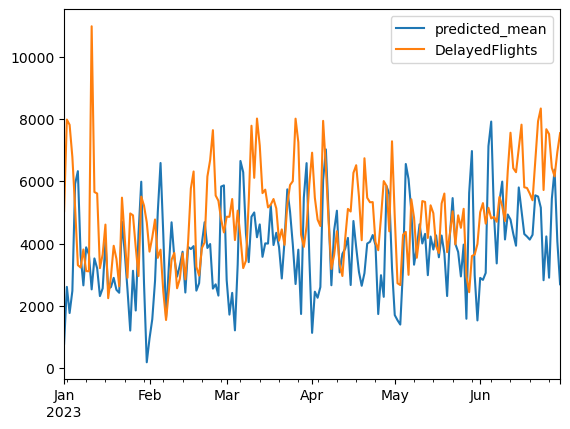

In [57]:
df_res_val.plot(y=['predicted_mean', 'DelayedFlights'])

### Can we predict for specific airlines?

In [58]:
# Let's look at this by airline

qstr = '''
select FlightDate, Reporting_Airline, count(*) as TotalFlights, count(distinct Tail_Number) as Aircraft,
mean(Distance) as Distance, 
mean(case when "YEAR MFR"!='    ' then cast("YEAR MFR" as Integer) end) as YearMfr,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights,
count(case when MFR_aircraft like '%AIRBUS%' then MFR_aircraft end) as AirbusFlights,
count(case when MFR_aircraft like '%BOEING%' then MFR_aircraft end) as BoeingFlights,
count(case when MFR_aircraft like '%EMBRAER%' then MFR_aircraft end) as EmbraerFlights,
count(case when MFR like 'CFM%' then MFR end) as CFMFlights,
count(case when MFR like 'GE%' then MFR end) as GEFlights,
count(case when MFR like 'P%' then MFR end) as PWFlights,
count(case when MFR like 'ROLL%' then MFR end) as RRFlights,
from 'bts_faa_coords.parquet'
group by FlightDate, Reporting_Airline
order by Reporting_Airline, FlightDate
'''

df_airline = duckdb.query(qstr).df()
df_airline.FlightDate = pd.to_datetime(df_airline.FlightDate)
df_airline = df_airline.set_index('FlightDate')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [59]:
df_airline

,Reporting_Airline,TotalFlights,Aircraft,Distance,YearMfr,DelayedFlights,DivertedFlights,CancelledFlights,AirbusFlights,BoeingFlights,EmbraerFlights,CFMFlights,GEFlights,PWFlights,RRFlights
FlightDate,,,,,,,,,,,,,,,
2018-01-01,9E,430,120,452.816279,2008.183099,133,0,0,0,0,0,0,426,0,0
2018-01-02,9E,653,134,473.577335,2008.064815,182,0,2,0,0,0,0,648,0,0
2018-01-03,9E,555,127,484.136937,2008.103636,113,1,34,0,0,0,0,550,0,0
2018-01-04,9E,550,126,488.749091,2008.325967,54,0,277,0,0,0,0,543,0,0
2018-01-05,9E,553,130,491.251356,2008.160878,183,0,108,0,0,0,0,547,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,YX,827,181,482.777509,2010.249386,257,3,329,0,0,826,0,814,0,0
2023-06-27,YX,814,179,482.750614,2010.358302,183,5,357,0,0,812,0,801,0,0
2023-06-28,YX,812,178,486.889163,2010.353750,238,1,75,0,0,810,0,800,0,0


### Delta

In [67]:
df_train_dl = df_airline[df_airline.Reporting_Airline=='DL'][:'2018-12-31']
df_test_dl = df_airline[df_airline.Reporting_Airline=='DL']['2019-01-01':'2019-12-31']

In [68]:
exog_cols = ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights']
exog = df_train_dl[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train_dl.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(2,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30670D+01    |proj g|=  1.65639D+01

At iterate    5    f=  6.89806D+00    |proj g|=  1.38753D-01

At iterate   10    f=  6.89701D+00    |proj g|=  7.11529D-03

At iterate   15    f=  6.89696D+00    |proj g|=  2.30961D-02

At iterate   20    f=  6.89658D+00    |proj g|=  1.25545D-02

At iterate   25    f=  6.89657D+00    |proj g|=  7.01241D-03

At iterate   30    f=  6.89628D+00    |proj g|=  2.71445D-02

At iterate   35    f=  6.89551D+00    |proj g|=  4.70035D-03

At iterate   40    f=  6.89547D+00    |proj g|=  6.58272D-03

At iterate   45    f=  6.89485D+00    |proj g|=  5.43550D-02

At iterate   50    f=  6.89386D+00    |proj g|=  7.41285D-03

At iterate   55    f=  6.89383D+00    |proj g|=  6.28014D-03

At iterate   60    f=  6.89381D+00    |proj g|=  2.86772D-03

At iterate   65    f=  6.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood               -9771.315
Date:                             Sun, 15 Oct 2023   AIC                          19564.629
Time:                                     21:12:32   BIC                          19622.557
Sample:                                 01-01-2015   HQIC                         19586.260
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Aircraft          3.6325      0.845      4.301      0.000       1.977       5.288
Distance          1.3094      0.287      4.563      0.000       0.747       1.872
YearMfr          -1.4557      0.432     -3.370      0.001      -2.302      -0.609
AirbusFlights    -0.1738      0.323     -0.538      0.591      -0.807       0.459
BoeingFlights     0.4415      0.144      3.056      0.002       0.158       0.725
ar.L1             0.8142      0.044     18.586      0.000       0.728       0.900
ma.L1            -0.3490      0.051     -6.789      0.000      -0.450      -0.248
ma.L2            -0.1698      0.038     -4.411      0.000      -0.245      -0.094
ar.S.L30         -0.6158      0.021    -28.796      0.000      -0.658      -0.574
ar.S.L60         -0.3188      0.022    -14.335      0.000      -0.362      -0.275
sigma2         4.956e+04   1206.454     41.076      0.000    4.72e+04    5.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               740.71
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.78
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean      542.024615
DelayedFlights      499.200000
Error               -42.824615
PctError             -0.273551
AbsoluteError       211.855227
AbsolutePctError      0.535640
dtype: float64

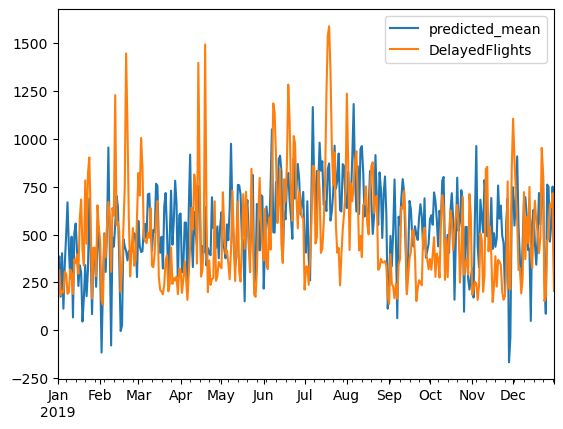

In [69]:
exog_test = df_test_dl[exog_cols]

df_res_dl = pd.DataFrame([results.forecast(365, exog=exog_test), df_test_dl.DelayedFlights]).T
df_res_dl.plot()

df_res_dl['Error'] = df_res_dl.DelayedFlights - df_res_dl.predicted_mean
df_res_dl['PctError'] = df_res_dl.Error/df_res_dl.DelayedFlights
df_res_dl['AbsoluteError'] = df_res_dl.Error.abs()
df_res_dl['AbsolutePctError'] = df_res_dl.PctError.abs()
df_res_dl.mean()

### United

In [70]:
df_train_ua = df_airline[df_airline.Reporting_Airline=='UA'][:'2018-12-31']
df_test_ua = df_airline[df_airline.Reporting_Airline=='UA']['2019-01-01':'2019-12-31']

In [71]:
exog_cols = ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights']
exog = df_train_ua[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train_ua.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(3,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02393D+01    |proj g|=  9.97622D+00

At iterate    5    f=  6.40299D+00    |proj g|=  4.24793D-02

At iterate   10    f=  6.40144D+00    |proj g|=  1.17255D-02

At iterate   15    f=  6.40026D+00    |proj g|=  5.18019D-02

At iterate   20    f=  6.39999D+00    |proj g|=  7.02678D-03

At iterate   25    f=  6.39954D+00    |proj g|=  1.18807D-02

At iterate   30    f=  6.39924D+00    |proj g|=  6.50587D-03

At iterate   35    f=  6.39532D+00    |proj g|=  1.31855D-01

At iterate   40    f=  6.36676D+00    |proj g|=  1.01203D-01

At iterate   45    f=  6.35324D+00    |proj g|=  7.98961D-02

At iterate   50    f=  6.35029D+00    |proj g|=  1.14022D-02

At iterate   55    f=  6.34965D+00    |proj g|=  1.48436D-02

At iterate   60    f=  6.34953D+00    |proj g|=  1.63656D-03

At iterate   65    f=  6.3

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate  200    f=  6.15745D+00    |proj g|=  1.01113D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12    200    222      1     0     0   1.011D-03   6.157D+00
  F =   6.1574479281241521     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 30)   Log Likelihood               -8996.031
Date:                             Sun, 15 Oct 2023   AIC                          18016.063
Time:                                     21:40:37   BIC                          18079.256
Sample:                                 01-01-2015   HQIC                         18039.660
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Aircraft          0.2678      0.392      0.684      0.494      -0.500       1.035
Distance          0.2951      0.137      2.155      0.031       0.027       0.564
YearMfr          -0.0827      0.460     -0.180      0.857      -0.984       0.818
AirbusFlights     0.3300      0.145      2.283      0.022       0.047       0.613
BoeingFlights     0.4292      0.084      5.090      0.000       0.264       0.594
ar.L1             0.9286      0.020     46.887      0.000       0.890       0.967
ma.L1            -0.4779      0.033    -14.350      0.000      -0.543      -0.413
ma.L2            -0.2108      0.031     -6.757      0.000      -0.272      -0.150
ar.S.L30         -0.7766      0.025    -31.595      0.000      -0.825      -0.728
ar.S.L60         -0.4970      0.030    -16.824      0.000      -0.555      -0.439
ar.S.L90         -0.2254      0.027     -8.357      0.000      -0.278      -0.173
sigma2          1.68e+04    515.985     32.568      0.000    1.58e+04    1.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               177.86
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.61
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean      398.666399
DelayedFlights      430.101370
Error                31.434971
PctError             -0.051798
AbsoluteError       137.376626
AbsolutePctError      0.348454
dtype: float64

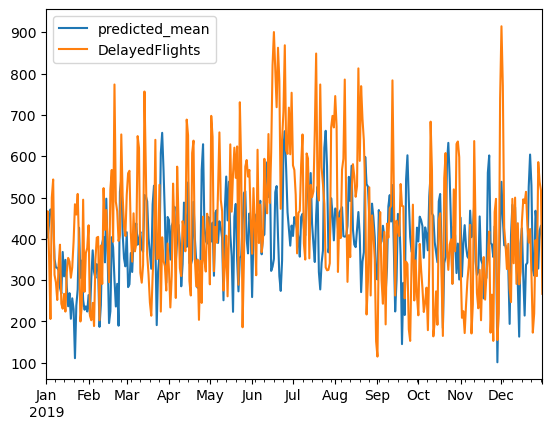

In [72]:
exog_test = df_test_ua[exog_cols]

df_res_ua = pd.DataFrame([results.forecast(365, exog=exog_test), df_test_ua.DelayedFlights]).T
df_res_ua.plot()

df_res_ua['Error'] = df_res_ua.DelayedFlights - df_res_ua.predicted_mean
df_res_ua['PctError'] = df_res_ua.Error/df_res_ua.DelayedFlights
df_res_ua['AbsoluteError'] = df_res_ua.Error.abs()
df_res_ua['AbsolutePctError'] = df_res_ua.PctError.abs()
df_res_ua.mean()

### American

In [121]:
df_train_aa = df_airline[df_airline.Reporting_Airline=='UA'][:'2018-12-31']
df_test_aa = df_airline[df_airline.Reporting_Airline=='UA']['2019-01-01':'2019-12-31']

In [122]:
# exog_cols = ['Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights']
# Won't use FAA data for AA due to errors in tail numbers
exog_cols = ['Aircraft','Distance']

exog = df_train_aa[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train_aa.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(2,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28070D+00    |proj g|=  3.90524D-02


 This problem is unconstrained.



At iterate    5    f=  6.26967D+00    |proj g|=  8.91468D-03

At iterate   10    f=  6.26098D+00    |proj g|=  5.56780D-03

At iterate   15    f=  6.25903D+00    |proj g|=  2.09763D-02

At iterate   20    f=  6.24740D+00    |proj g|=  8.76208D-02

At iterate   25    f=  6.21886D+00    |proj g|=  7.53539D-03

At iterate   30    f=  6.21855D+00    |proj g|=  7.78853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     37      1     0     0   2.668D-05   6.219D+00
  F =   6.2185483912864026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood               -9085.299
Date:                             Sat, 14 Oct 2023   AIC                          18186.598
Time:                                     17:09:06   BIC                          18228.727
Sample:                                 01-01-2015   HQIC                         18202.330
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Aircraft       2.7537      0.217     12.668      0.000       2.328       3.180
Distance      -0.5088      0.097     -5.218      0.000      -0.700      -0.318
ar.L1          0.9994      0.004    268.027      0.000       0.992       1.007
ma.L1         -0.5247      0.024    -22.126      0.000      -0.571      -0.478
ma.L2         -0.2722      0.025    -11.056      0.000      -0.321      -0.224
ar.S.L30      -0.7298      0.023    -32.043      0.000      -0.774      -0.685
ar.S.L60      -0.3450      0.023    -14.706      0.000      -0.391      -0.299
sigma2      1.896e+04    612.903     30.940      0.000    1.78e+04    2.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                74.33
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.37
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean      714.818808
DelayedFlights      430.101370
Error              -284.717438
PctError             -0.940045
AbsoluteError       308.066769
AbsolutePctError      0.977091
dtype: float64

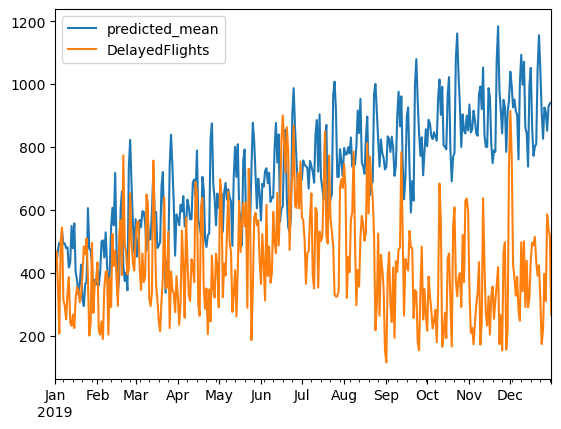

In [123]:
exog_test = df_test_aa[exog_cols]

df_res_aa = pd.DataFrame([results.forecast(365, exog=exog_test), df_test_aa.DelayedFlights]).T
df_res_aa.plot()

df_res_aa['Error'] = df_res_aa.DelayedFlights - df_res_aa.predicted_mean
df_res_aa['PctError'] = df_res_aa.Error/df_res_aa.DelayedFlights
df_res_aa['AbsoluteError'] = df_res_aa.Error.abs()
df_res_aa['AbsolutePctError'] = df_res_aa.PctError.abs()
df_res_aa.mean()

### Southwest

In [124]:
df_train_wn = df_airline[df_airline.Reporting_Airline=='WN'][:'2018-12-31']
df_test_wn = df_airline[df_airline.Reporting_Airline=='WN']['2019-01-01':'2019-12-31']

In [129]:
# For Southwest, all aircraft are Boeing so BoeingFlights is basically the total flight count
exog_cols = ['Aircraft','Distance','YearMfr','BoeingFlights']

exog = df_train_wn[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train_wn.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(2,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04672D+01    |proj g|=  7.34557D+00


 This problem is unconstrained.



At iterate    5    f=  7.25401D+00    |proj g|=  4.36661D-01

At iterate   10    f=  7.24090D+00    |proj g|=  4.54432D-02

At iterate   15    f=  7.24065D+00    |proj g|=  5.73063D-03

At iterate   20    f=  7.23888D+00    |proj g|=  1.66134D-01

At iterate   25    f=  7.22938D+00    |proj g|=  5.26974D-02

At iterate   30    f=  7.22797D+00    |proj g|=  3.52467D-03

At iterate   35    f=  7.22648D+00    |proj g|=  5.04157D-02

At iterate   40    f=  7.19146D+00    |proj g|=  2.31270D-01

At iterate   45    f=  7.09897D+00    |proj g|=  3.28363D-02

At iterate   50    f=  7.08285D+00    |proj g|=  5.62928D-02

At iterate   55    f=  7.05725D+00    |proj g|=  3.36592D-03

At iterate   60    f=  7.05166D+00    |proj g|=  4.94922D-02

At iterate   65    f=  7.02369D+00    |proj g|=  7.36940D-02

At iterate   70    f=  6.99996D+00    |proj g|=  8.17416D-03

At iterate   75    f=  6.99765D+00    |proj g|=  1.32985D-02

At iterate   80    f=  6.99612D+00    |proj g|=  8.71980D-03

At iter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood              -10156.512
Date:                             Sat, 14 Oct 2023   AIC                          20335.025
Time:                                     17:29:21   BIC                          20392.952
Sample:                                 01-01-2015   HQIC                         20356.656
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Aircraft          2.9415      1.417      2.076      0.038       0.164       5.719
Distance          2.5014      0.569      4.398      0.000       1.387       3.616
YearMfr          -2.1363      0.627     -3.408      0.001      -3.365      -0.908
BoeingFlights     0.5421      0.048     11.297      0.000       0.448       0.636
AirbusFlights          0    8.1e+04          0      1.000   -1.59e+05    1.59e+05
ar.L1             0.9070      0.022     42.020      0.000       0.865       0.949
ma.L1            -0.3242      0.034     -9.412      0.000      -0.392      -0.257
ma.L2            -0.2667      0.033     -8.124      0.000      -0.331      -0.202
ar.S.L30         -0.6897      0.026    -26.821      0.000      -0.740      -0.639
ar.S.L60         -0.3513      0.025    -13.937      0.000      -0.401      -0.302
sigma2         8.482e+04   2724.278     31.135      0.000    7.95e+04    9.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                83.61
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.42
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean             957.015326
DelayedFlights             430.101370
Error                     -526.913956
PctError                    -1.494060
AbsoluteError              534.040030
AbsolutePctError             1.511011
predicted_mean_shifted     431.015326
ShiftedError                -0.913956
ShiftedPctError             -0.067856
ShiftedAbsoluteError       249.824186
ShiftedAbsolutePctError      0.682776
dtype: float64

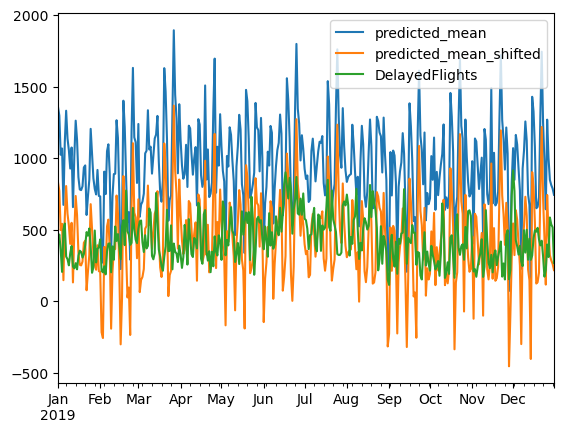

In [140]:
exog_test = df_test_wn[exog_cols]

df_res_wn = pd.DataFrame([results.forecast(365, exog=exog_test), df_test_aa.DelayedFlights]).T
#df_res_wn.plot()

df_res_wn['Error'] = df_res_wn.DelayedFlights - df_res_wn.predicted_mean
df_res_wn['PctError'] = df_res_wn.Error/df_res_wn.DelayedFlights
df_res_wn['AbsoluteError'] = df_res_wn.Error.abs()
df_res_wn['AbsolutePctError'] = df_res_wn.PctError.abs()
df_res_wn['predicted_mean_shifted'] = (df_res_wn['predicted_mean'] - 526)
df_res_wn['ShiftedError'] = df_res_wn.DelayedFlights - df_res_wn.predicted_mean_shifted
df_res_wn['ShiftedPctError'] = df_res_wn.ShiftedError/df_res_wn.DelayedFlights
df_res_wn['ShiftedAbsoluteError'] = df_res_wn.ShiftedError.abs()
df_res_wn['ShiftedAbsolutePctError'] = df_res_wn.ShiftedPctError.abs()


df_res_wn.plot(y=['predicted_mean', 'predicted_mean_shifted', 'DelayedFlights'])

df_res_wn.mean()

### Spirit

In [141]:
df_train_nk = df_airline[df_airline.Reporting_Airline=='NK'][:'2018-12-31']
df_test_nk = df_airline[df_airline.Reporting_Airline=='NK']['2019-01-01':'2019-12-31']

In [143]:
# For Spirit, all aircraft are Airbus so AirbusFlights is basically the total flight count
exog_cols = ['Aircraft','Distance','YearMfr','AirbusFlights']

exog = df_train_nk[exog_cols]

model = sm.tsa.statespace.SARIMAX(df_train_nk.DelayedFlights,
                                  order=(1, 0, 2),
                                  seasonal_order=(2,1,0,30),
                                  exog = exog)

results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05837D+00    |proj g|=  1.73877D-02


 This problem is unconstrained.



At iterate    5    f=  5.05094D+00    |proj g|=  3.33449D-02

At iterate   10    f=  5.03910D+00    |proj g|=  1.79739D-02

At iterate   15    f=  5.02158D+00    |proj g|=  1.16727D-02

At iterate   20    f=  5.01823D+00    |proj g|=  2.21509D-03

At iterate   25    f=  5.01577D+00    |proj g|=  2.57839D-02

At iterate   30    f=  5.01093D+00    |proj g|=  3.08053D-03

At iterate   35    f=  5.01086D+00    |proj g|=  1.13779D-03

At iterate   40    f=  5.01057D+00    |proj g|=  2.52816D-03

At iterate   45    f=  5.01056D+00    |proj g|=  8.62394D-05

At iterate   50    f=  5.01056D+00    |proj g|=  1.22477D-03

At iterate   55    f=  5.01054D+00    |proj g|=  2.95414D-04

At iterate   60    f=  5.01054D+00    |proj g|=  3.39597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DelayedFlights   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood               -7320.400
Date:                             Sat, 14 Oct 2023   AIC                          14660.800
Time:                                     17:44:19   BIC                          14713.461
Sample:                                 01-01-2015   HQIC                         14680.464
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Aircraft          0.3683      0.672      0.548      0.584      -0.950       1.686
Distance          0.0457      0.160      0.285      0.775      -0.268       0.360
YearMfr           2.2042      2.002      1.101      0.271      -1.721       6.129
AirbusFlights     0.3075      0.095      3.238      0.001       0.121       0.494
ar.L1             0.9532      0.014     68.627      0.000       0.926       0.980
ma.L1            -0.4662      0.028    -16.765      0.000      -0.521      -0.412
ma.L2            -0.2912      0.027    -10.682      0.000      -0.345      -0.238
ar.S.L30         -0.6522      0.023    -28.570      0.000      -0.697      -0.607
ar.S.L60         -0.3138      0.024    -13.248      0.000      -0.360      -0.267
sigma2         1607.3494     47.949     33.522      0.000    1513.371    1701.328
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):               211.40
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

predicted_mean      128.629285
DelayedFlights      127.593407
Error                -1.044945
PctError             -0.245222
AbsoluteError        50.932794
AbsolutePctError      0.514403
dtype: float64

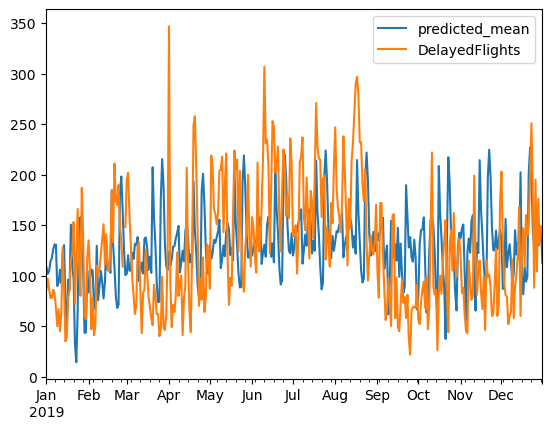

In [162]:
exog_test = df_test_nk[exog_cols].copy()
# Insert missing data
exog_test.loc['2019-02-27'] = exog_test.loc['2019-02-26']

df_res_nk = pd.DataFrame([results.forecast(365, exog=exog_test), df_test_nk.DelayedFlights]).T
df_res_nk.plot()

df_res_nk['Error'] = df_res_nk.DelayedFlights - df_res_nk.predicted_mean
df_res_nk['PctError'] = df_res_nk.Error/df_res_nk.DelayedFlights
df_res_nk['AbsoluteError'] = df_res_nk.Error.abs()
df_res_nk['AbsolutePctError'] = df_res_nk.PctError.abs()
df_res_nk.mean()